In [1]:
import sqlite3
import pandas as pd
import filterbyip as fbi
import clusterbycolumn as cbc
import requests
import asinfo

import matplotlib.dates as dates
from datetime import datetime as dt

In [2]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [4]:
def asn_from_probe_name(probe_name):
    base = 'http://leone-collector.eecs.jacobs-university.de/msmpoint'
    msm_metadata = requests.get('%s/%s'%(base, probe_name))
    asn4 = str(msm_metadata.json()['asn4'])
    asn6 = str(msm_metadata.json()['asn6'])
    return asn4,asn6

In [5]:
dailydb_location = '/data/vbajpai/datasets/youtube-data-collection-python3/youtube.db'

In [6]:
query = '''select   msmpoint.name as probe
                  , dtime
                  , video_address
                  , web_connect_time as w_time
                  , audio_connect_time as a_time
                  , video_connect_time as v_time
                  , startup_delay
                  , prebuffering_duration as pd
           from youtube, msmpoint
           where youtube.unit_id = msmpoint.skunitid
           and msmpoint.skunitid <> ''
           and successes = 1
           and failures = 0;
        '''

In [7]:
con = sqlite3.connect(dailydb_location)
df = pd.read_sql(query, con)

In [8]:
df.count()

probe            4422465
dtime            4422465
video_address    4422465
w_time           4346299
a_time           4422465
v_time           4422465
startup_delay    4346299
pd               4422465
dtype: int64

In [9]:
df.head()

,probe,dtime,video_address,w_time,a_time,v_time,startup_delay,pd
0,samsbox81,2016-09-05 16:29:41,193.212.4.15,6916.0,8731,7658,1179709.0,528170
1,samsbox81,2016-09-05 16:30:23,2001:4600:9:307::f,17844.0,11176,10076,1046380.0,542534
2,samsbox81,2016-09-05 17:26:17,193.212.4.15,7122.0,8904,7760,1050626.0,538893
3,samsbox81,2016-09-05 17:26:59,2001:4600:9:307::f,17781.0,11010,9826,1033682.0,544550
4,samsbox81,2016-09-05 18:25:53,193.212.4.15,8110.0,9015,7859,1087679.0,558563


In [10]:
def round_time_to_nearest_hour(dtime):
    import datetime;    
    d = datetime.datetime.strptime(dtime, "%Y-%m-%d %H:%M:%S")
    d = d.replace(minute=0, second=0)
    dtime = d.strftime('%Y-%m-%d %H:%M:%S')
    return dtime

In [11]:
df['dtime'] = df['dtime'].apply(round_time_to_nearest_hour)

In [12]:
df.head()

,probe,dtime,video_address,w_time,a_time,v_time,startup_delay,pd
0,samsbox81,2016-09-05 16:00:00,193.212.4.15,6916.0,8731,7658,1179709.0,528170
1,samsbox81,2016-09-05 16:00:00,2001:4600:9:307::f,17844.0,11176,10076,1046380.0,542534
2,samsbox81,2016-09-05 17:00:00,193.212.4.15,7122.0,8904,7760,1050626.0,538893
3,samsbox81,2016-09-05 17:00:00,2001:4600:9:307::f,17781.0,11010,9826,1033682.0,544550
4,samsbox81,2016-09-05 18:00:00,193.212.4.15,8110.0,9015,7859,1087679.0,558563


In [13]:
num_probes = len(set(df['probe']))

In [14]:
df.count()

probe            4422465
dtime            4422465
video_address    4422465
w_time           4346299
a_time           4422465
v_time           4422465
startup_delay    4346299
pd               4422465
dtype: int64

In [15]:
df = df.dropna()

In [16]:
df.count()

probe            4346299
dtime            4346299
video_address    4346299
w_time           4346299
a_time           4346299
v_time           4346299
startup_delay    4346299
pd               4346299
dtype: int64

In [17]:
def filter_by_ip(df, column):
  """reads a DataFrame, calls fbi.filter_v{4,6} to get DataFrames with rows
     containing only v4, v6 endpoints. Returns the two DataFrame as a tuple"""

  dfv6 = fbi.filter_v6(df, column)
  dfv4 = fbi.filter_v4(df, column)
  return dfv4, dfv6

In [18]:
dfv4, dfv6 = filter_by_ip(df, column = 'video_address')

In [19]:
dfv4['name'] = dfv4['probe'].apply(lambda name: "#%02d"%int(name[7:]))
dfv6['name'] = dfv6['probe'].apply(lambda name: "#%02d"%int(name[7:]))
del dfv4['probe']; del dfv6['probe']

In [20]:
dfv4.head()

,dtime,video_address,w_time,a_time,v_time,startup_delay,pd,name
0,2016-09-05 16:00:00,193.212.4.15,6916.0,8731,7658,1179709.0,528170,#81
2,2016-09-05 17:00:00,193.212.4.15,7122.0,8904,7760,1050626.0,538893,#81
4,2016-09-05 18:00:00,193.212.4.15,8110.0,9015,7859,1087679.0,558563,#81
6,2016-09-05 19:00:00,193.212.4.15,9605.0,9016,7965,1004614.0,555959,#81
8,2016-09-05 20:00:00,193.212.4.15,8338.0,8737,7546,1034223.0,506325,#81


In [21]:
dfv6.head()

,dtime,video_address,w_time,a_time,v_time,startup_delay,pd,name
1,2016-09-05 16:00:00,2001:4600:9:307::f,17844.0,11176,10076,1046380.0,542534,#81
3,2016-09-05 17:00:00,2001:4600:9:307::f,17781.0,11010,9826,1033682.0,544550,#81
5,2016-09-05 18:00:00,2001:4600:9:307::f,18504.0,11124,9995,1063464.0,547832,#81
7,2016-09-05 19:00:00,2001:4600:9:307::f,17403.0,10914,9753,1057225.0,549447,#81
9,2016-09-05 20:00:00,2001:4600:9:307::f,17382.0,11195,9736,918502.0,443459,#81


In [22]:
df = pd.merge(dfv4, dfv6, on=["name", "dtime"])

In [23]:
df.count()

dtime              6549945
video_address_x    6549945
w_time_x           6549945
a_time_x           6549945
v_time_x           6549945
startup_delay_x    6549945
pd_x               6549945
name               6549945
video_address_y    6549945
w_time_y           6549945
a_time_y           6549945
v_time_y           6549945
startup_delay_y    6549945
pd_y               6549945
dtype: int64

In [24]:
df.rename(columns={  'video_address_x'      : 'v_ep_v4'
                   , 'w_time_x'             : 'w_v4'
                   , 'a_time_x'             : 'a_v4'
                   , 'v_time_x'             : 'v_v4'                   
                   , 'startup_delay_x'      : 's_v4'             
                   , 'pd_x'                 : 'pd_v4'                           
                   , 'video_address_y'      : 'v_ep_v6'
                   , 'w_time_y'             : 'w_v6'
                   , 'a_time_y'             : 'a_v6'
                   , 'v_time_y'             : 'v_v6'                   
                   , 'startup_delay_y'      : 's_v6'             
                   , 'pd_y'                 : 'pd_v6'                                              
                  } ,  inplace=True)

In [25]:
df.head()

,dtime,v_ep_v4,w_v4,a_v4,v_v4,s_v4,pd_v4,name,v_ep_v6,w_v6,a_v6,v_v6,s_v6,pd_v6
0,2016-09-05 16:00:00,193.212.4.15,6916.0,8731,7658,1179709.0,528170,#81,2001:4600:9:307::f,17844.0,11176,10076,1046380.0,542534
1,2016-09-05 17:00:00,193.212.4.15,7122.0,8904,7760,1050626.0,538893,#81,2001:4600:9:307::f,17781.0,11010,9826,1033682.0,544550
2,2016-09-05 18:00:00,193.212.4.15,8110.0,9015,7859,1087679.0,558563,#81,2001:4600:9:307::f,18504.0,11124,9995,1063464.0,547832
3,2016-09-05 19:00:00,193.212.4.15,9605.0,9016,7965,1004614.0,555959,#81,2001:4600:9:307::f,17403.0,10914,9753,1057225.0,549447
4,2016-09-05 20:00:00,193.212.4.15,8338.0,8737,7546,1034223.0,506325,#81,2001:4600:9:307::f,17382.0,11195,9736,918502.0,443459


In [26]:
df.count()

dtime      6549945
v_ep_v4    6549945
w_v4       6549945
a_v4       6549945
v_v4       6549945
s_v4       6549945
pd_v4      6549945
name       6549945
v_ep_v6    6549945
w_v6       6549945
a_v6       6549945
v_v6       6549945
s_v6       6549945
pd_v6      6549945
dtype: int64

In [27]:
df['v4v6_p']  = df.pd_v4.map(str) + ',' + df.pd_v6.map(str)
df['v4v6_s']  = df.s_v4.map(str)  + ',' + df.s_v6.map(str)
df['v4v6_w']  = df.w_v4.map(str)  + ',' + df.w_v6.map(str)
df['v4v6_a']  = df.a_v4.map(str)  + ',' + df.a_v6.map(str)
df['v4v6_v']  = df.v_v4.map(str)  + ',' + df.v_v6.map(str)

In [28]:
df.head()

,dtime,v_ep_v4,w_v4,a_v4,v_v4,s_v4,pd_v4,name,v_ep_v6,w_v6,a_v6,v_v6,s_v6,pd_v6,v4v6_p,v4v6_s,v4v6_w,v4v6_a,v4v6_v
0,2016-09-05 16:00:00,193.212.4.15,6916.0,8731,7658,1179709.0,528170,#81,2001:4600:9:307::f,17844.0,11176,10076,1046380.0,542534,"528170,542534","1179709.0,1046380.0","6916.0,17844.0","8731,11176","7658,10076"
1,2016-09-05 17:00:00,193.212.4.15,7122.0,8904,7760,1050626.0,538893,#81,2001:4600:9:307::f,17781.0,11010,9826,1033682.0,544550,"538893,544550","1050626.0,1033682.0","7122.0,17781.0","8904,11010","7760,9826"
2,2016-09-05 18:00:00,193.212.4.15,8110.0,9015,7859,1087679.0,558563,#81,2001:4600:9:307::f,18504.0,11124,9995,1063464.0,547832,"558563,547832","1087679.0,1063464.0","8110.0,18504.0","9015,11124","7859,9995"
3,2016-09-05 19:00:00,193.212.4.15,9605.0,9016,7965,1004614.0,555959,#81,2001:4600:9:307::f,17403.0,10914,9753,1057225.0,549447,"555959,549447","1004614.0,1057225.0","9605.0,17403.0","9016,10914","7965,9753"
4,2016-09-05 20:00:00,193.212.4.15,8338.0,8737,7546,1034223.0,506325,#81,2001:4600:9:307::f,17382.0,11195,9736,918502.0,443459,"506325,443459","1034223.0,918502.0","8338.0,17382.0","8737,11195","7546,9736"


### Calculate Absolute Difference

In [29]:
def get_difference(v4v6_delay, divider):
    
    v4, v6 = v4v6_delay.split(',')
    try: v4 = float(v4); v6 = float(v6)
    except Exception as e: print(e, v4v6_delay)
    
    difference = (v4 - v6)
    difference = difference / divider              
    return float('%0.2f'%difference)

def get_s_delay_difference(v4v6_s_delay):
    return get_difference(v4v6_s_delay, 1000) # to milliseconds

def get_t_delay_difference(v4v6_t_delay):
    return get_difference(v4v6_t_delay, 1000) # to milliseconds

df['p_a'] = df['v4v6_p'].apply(get_s_delay_difference)
df['s_a'] = df['v4v6_s'].apply(get_s_delay_difference)

df['w_a'] = df['v4v6_w'].apply(get_t_delay_difference)
df['a_a'] = df['v4v6_a'].apply(get_t_delay_difference)
df['v_a'] = df['v4v6_v'].apply(get_t_delay_difference)

### Calculate Relative Difference

In [30]:
def get_slowness(v4v6_s_delay):
    
    v4, v6 = v4v6_s_delay.split(',')
    try: v4 = float(v4); v6 = float(v6)
    except Exception as e: print(e, v4v6_s_delay)
    
    try: slowness = (v4 - v6) / v4
    except Exception as e: return 0
    return float('%0.2f'%slowness)

df['p_r'] = df['v4v6_p'].apply(get_slowness)
df['s_r'] = df['v4v6_s'].apply(get_slowness)
df['w_r'] = df['v4v6_w'].apply(get_slowness)
df['a_r'] = df['v4v6_a'].apply(get_slowness)
df['v_r'] = df['v4v6_v'].apply(get_slowness)

In [31]:
del df['v4v6_p']
del df['v4v6_s']
del df['v4v6_w']
del df['v4v6_a']
del df['v4v6_v']

In [32]:
df.count()

dtime      6549945
v_ep_v4    6549945
w_v4       6549945
a_v4       6549945
v_v4       6549945
s_v4       6549945
pd_v4      6549945
name       6549945
v_ep_v6    6549945
w_v6       6549945
a_v6       6549945
v_v6       6549945
s_v6       6549945
pd_v6      6549945
p_a        6549945
s_a        6549945
w_a        6549945
a_a        6549945
v_a        6549945
p_r        6549945
s_r        6549945
w_r        6549945
a_r        6549945
v_r        6549945
dtype: int64

In [33]:
del df['v_ep_v4']; del df['v_ep_v6']

In [34]:
df.head()

,dtime,w_v4,a_v4,v_v4,s_v4,pd_v4,name,w_v6,a_v6,v_v6,...,p_a,s_a,w_a,a_a,v_a,p_r,s_r,w_r,a_r,v_r
0,2016-09-05 16:00:00,6916.0,8731,7658,1179709.0,528170,#81,17844.0,11176,10076,...,-14.36,133.33,-10.93,-2.44,-2.42,-0.03,0.11,-1.58,-0.28,-0.32
1,2016-09-05 17:00:00,7122.0,8904,7760,1050626.0,538893,#81,17781.0,11010,9826,...,-5.66,16.94,-10.66,-2.11,-2.07,-0.01,0.02,-1.50,-0.24,-0.27
2,2016-09-05 18:00:00,8110.0,9015,7859,1087679.0,558563,#81,18504.0,11124,9995,...,10.73,24.21,-10.39,-2.11,-2.14,0.02,0.02,-1.28,-0.23,-0.27
3,2016-09-05 19:00:00,9605.0,9016,7965,1004614.0,555959,#81,17403.0,10914,9753,...,6.51,-52.61,-7.80,-1.90,-1.79,0.01,-0.05,-0.81,-0.21,-0.22
4,2016-09-05 20:00:00,8338.0,8737,7546,1034223.0,506325,#81,17382.0,11195,9736,...,62.87,115.72,-9.04,-2.46,-2.19,0.12,0.11,-1.08,-0.28,-0.29


In [35]:
def round_time_to_day(dtime):
    import datetime;    
    d = datetime.datetime.strptime(dtime, "%Y-%m-%d %H:%M:%S")
    d = d.replace(hour=0, minute=0, second=0)
    dtime = d.strftime('%Y-%m-%d')
    return dtime

df['dtime'] = df['dtime'].apply(round_time_to_day)

In [36]:
df.head()

,dtime,w_v4,a_v4,v_v4,s_v4,pd_v4,name,w_v6,a_v6,v_v6,...,p_a,s_a,w_a,a_a,v_a,p_r,s_r,w_r,a_r,v_r
0,2016-09-05,6916.0,8731,7658,1179709.0,528170,#81,17844.0,11176,10076,...,-14.36,133.33,-10.93,-2.44,-2.42,-0.03,0.11,-1.58,-0.28,-0.32
1,2016-09-05,7122.0,8904,7760,1050626.0,538893,#81,17781.0,11010,9826,...,-5.66,16.94,-10.66,-2.11,-2.07,-0.01,0.02,-1.50,-0.24,-0.27
2,2016-09-05,8110.0,9015,7859,1087679.0,558563,#81,18504.0,11124,9995,...,10.73,24.21,-10.39,-2.11,-2.14,0.02,0.02,-1.28,-0.23,-0.27
3,2016-09-05,9605.0,9016,7965,1004614.0,555959,#81,17403.0,10914,9753,...,6.51,-52.61,-7.80,-1.90,-1.79,0.01,-0.05,-0.81,-0.21,-0.22
4,2016-09-05,8338.0,8737,7546,1034223.0,506325,#81,17382.0,11195,9736,...,62.87,115.72,-9.04,-2.46,-2.19,0.12,0.11,-1.08,-0.28,-0.29


In [37]:
targets = ['p_a', 's_a', 'w_a', 'a_a', 'v_a', 'p_r', 's_r', 'w_r', 'a_r', 'v_r',
           'w_v4','a_v4', 'v_v4', 'w_v6', 'a_v6', 'v_v6', 's_v4', 's_v6', 'pd_v4','pd_v6']

def get_difference_across_probes(df):
    dfgroupby  = cbc.group(df, column=['dtime'])
    df_agg     = cbc.aggregate(dfgroupby, targets, ['median'])
    df_merged  = cbc.merge(df, df_agg, column=['dtime'])
    df         = df_merged.drop(targets + ['name'], axis=1)
    df         = df.drop_duplicates()
    df.columns = ['dtime'] + targets
    return df

df = get_difference_across_probes(df)

In [38]:
df['dtime'] = df['dtime'].apply(lambda d: dt.strptime(d, '%Y-%m-%d'))

In [39]:
df.sort_values(by = 'dtime', inplace = True)

In [40]:
def convert_to_ms(df, field):
    df[field] = df[field].div(1000) # milliseconds

targets = ['w_v4','a_v4', 'v_v4', 'w_v6', 'a_v6', 'v_v6', 's_v4', 's_v6', 'pd_v4','pd_v6']

for target in targets:
    convert_to_ms(df, target)

In [41]:
df.count()

dtime    929
p_a      929
s_a      929
w_a      929
a_a      929
v_a      929
p_r      929
s_r      929
w_r      929
a_r      929
v_r      929
w_v4     929
a_v4     929
v_v4     929
w_v6     929
a_v6     929
v_v6     929
s_v4     929
s_v6     929
pd_v4    929
pd_v6    929
dtype: int64

### Hardcoded dates

In [44]:
from dateutil import rrule
a=dt.strptime(str('2014-08-01'), '%Y-%m-%d')
b=dt.strptime(str('2017-07-01'), '%Y-%m-%d')
dateranges = rrule.rrule(rrule.DAILY, dtstart=a).between(a, b, inc=True)

In [45]:
df_ = pd.DataFrame(dateranges, columns=['dtime']).sort_values(by = 'dtime').reset_index(drop = True)

In [46]:
df = pd.merge(df_, df, how='outer')

In [50]:
def draw_inset(ax):
    
    df.plot(   x='dtime'
             , y=['w_a', 'a_a', 'v_a']
             , color=['cyan', 'green', 'wheat']
             , kind='line'
             , linewidth = 1
             , ax = ax
            )

    ax.grid(False)
    ax.set_xlabel('', fontsize=12)
    ax.legend(['Web', 'Audio', 'Video'], fontsize=12, loc='best', ncol = 3)
    ax.legend_.remove()
    ax.set_ylim([-0.4, 0])
    yticks = np.arange(-0.4,0.1,0.2)
    ax.set_yticks(yticks)

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.05))
    ax.spines['left'].set_position(('axes', -0.05))

In [56]:
import matplotlib.gridspec as gridspec

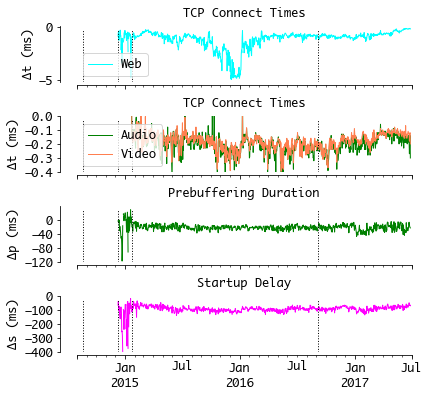

In [58]:
fig = plt.figure(figsize=(6, 6))
plt.rcParams['font.size'] = 12

ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412, sharex = ax1)
ax3 = fig.add_subplot(413, sharex = ax1)
ax4 = fig.add_subplot(414, sharex = ax1)

sl = df.plot(  x='dtime'
             , y=['w_a']
             , color='cyan'
             , kind='line'
             , linewidth = 1
             , ax = ax1
            )

ax1.grid(False)
ax1.set_xlabel('', fontsize=22)
ax1.set_ylabel('', fontsize=22)
ax1.set_yscale('linear')

ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.spines['bottom'].set_position(('axes', -0.05))
ax1.spines['left'].set_position(('axes', -0.05))

ax1.xaxis.set_major_locator(dates.YearLocator(1, month=1, day=1))
ax1.xaxis.set_major_formatter(dates.DateFormatter('\n%Y'))

ax1.set_xticklabels('')


sl = df.plot(  x='dtime'
             , y=['a_a', 'v_a']
             , color=['green', 'coral']
             , kind='line'
             , linewidth = 1
             , ax = ax2
            )

ax2.grid(False)
ax2.set_xlabel('', fontsize=22)
ax2.set_ylabel('', fontsize=22)
ax2.set_yscale('linear')
ax2.set_ylim([-0.4, 0])
yticks = np.arange(-0.4,0.1,0.1)
ax2.set_yticks(yticks)

ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('axes', -0.05))
ax2.spines['left'].set_position(('axes', -0.05))

ax2.xaxis.set_major_locator(dates.YearLocator(1, month=1, day=1))
ax2.xaxis.set_major_formatter(dates.DateFormatter('\n%Y'))

ax2.set_xticklabels('')

sl = df.plot(  x='dtime'
             , y=['p_a']
             , color='green'
             , kind='line'
             , linewidth = 1
             , ax = ax3
            )

ax3.grid(False)
ax3.set_xlabel('', fontsize=25)
ax3.set_ylabel('', fontsize=25)
ax3.set_yscale('linear')
ax3.set_ylim([-120, 41]); yticks = np.arange(-120,40,40)
ax3.set_yticks(yticks)

ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.spines['bottom'].set_position(('axes', -0.05))
ax3.spines['left'].set_position(('axes', -0.05))

ax3.set_xticklabels('')
     
sl = df.plot(  x='dtime'
             , y=['s_a']
             , color='magenta'
             , kind='line'
             , linewidth = 1
             , ax = ax4
            )

ax4.grid(False)
ax4.set_xlabel('', fontsize=25)
ax4.set_ylabel('', fontsize=25)
ax4.set_yscale('linear')
ax4.set_ylim([-400, 0])
yticks = np.arange(-400,10,100)
ax4.set_yticks(yticks)

ax4.spines['right'].set_color('none')
ax4.spines['top'].set_color('none')
ax4.yaxis.set_ticks_position('left')
ax4.xaxis.set_ticks_position('bottom')
ax4.spines['bottom'].set_position(('axes', -0.05))
ax4.spines['left'].set_position(('axes', -0.05))

ax1.legend(['Web'], fontsize=12, loc='lower left')   
ax2.legend(['Audio', 'Video'], fontsize=12, loc='best')   
ax3.legend_.remove()
ax4.legend_.remove()

ax1.set_title('TCP Connect Times', fontsize=12, y=1.05)
ax2.set_title('TCP Connect Times', fontsize=12, y=1.05)
ax3.set_title('Prebuffering Duration', fontsize=12, y=1.05)
ax4.set_title('Startup Delay', fontsize=12, y=1.05)

ax1.set_ylabel('∆t (ms)', fontsize=12)
ax2.set_ylabel('∆t (ms)', fontsize=12)
ax3.set_ylabel('∆p (ms)', fontsize=12)
ax4.set_ylabel('∆s (ms)', fontsize=12)

from datetime import datetime as dt
ax1.axvline(x=dt.strptime('2014-08-21', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax1.axvline(x=dt.strptime('2014-12-10', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax1.axvline(x=dt.strptime('2015-01-22', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax1.axvline(x=dt.strptime('2016-09-05', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')

ax2.axvline(x=dt.strptime('2014-08-21', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax2.axvline(x=dt.strptime('2014-12-10', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax2.axvline(x=dt.strptime('2015-01-22', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax2.axvline(x=dt.strptime('2016-09-05', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')

ax3.axvline(x=dt.strptime('2014-08-21', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax3.axvline(x=dt.strptime('2014-12-10', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax3.axvline(x=dt.strptime('2015-01-22', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax3.axvline(x=dt.strptime('2016-09-05', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')

ax4.axvline(x=dt.strptime('2014-08-21', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax4.axvline(x=dt.strptime('2014-12-10', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax4.axvline(x=dt.strptime('2015-01-22', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')
ax4.axvline(x=dt.strptime('2016-09-05', "%Y-%m-%d"), linewidth=1.0, ymax = 0.95, ymin = 0, color='black', ls = 'dotted')

fig.subplots_adjust(hspace = 0.6)

plt.savefig('youtube-delay-timeseries-separate.pdf', format='pdf', bbox_inches='tight')